In [240]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from pymongo import MongoClient
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [241]:
fake = Faker()


def is_holiday(date):
    # Assuming holidays fall on the same date each year
    return date.strftime('%m-%d') in ['12-25', '01-01', '01-07']


def generate_user():
    return {"username": fake.user_name(), "dob": fake.date_of_birth(tzinfo=None)}


def days_since_factor(days_since_last_order):
    if days_since_last_order <= 1:
        return -0.2  # Increased penalty for next-day orders
    elif 2 <= days_since_last_order <= 6:
        return -0.05  # Slightly increased penalty for orders within a week
    elif 7 <= days_since_last_order <= 14:
        return 0.1 * (days_since_last_order - 7)  # Lower positive impact
    else:
        return 0.5 + 0.03 * (days_since_last_order - 14)  # Lower diminishing returns

def generate_data(num_users, start_date, end_date, pizza_list):
    users = [generate_user() for _ in range(num_users)]
    dates = pd.date_range(start=start_date, end=end_date)
    possible_discounts = [0.0, 0.1, 0.2, 0.4, 0.5]
    records = []

    for user in users:
        last_order_date = None
        for day in dates:
            days_since_last_order = (day - last_order_date).days if last_order_date else 7
            days_since_factor_value = days_since_factor(days_since_last_order)

            holiday_boost = 0.35 if is_holiday(day) else 0
            birthday_boost = 0.4 if user["dob"].strftime('%m-%d') == day.strftime('%m-%d') else 0
            weekend_boost = 0.3 if day.weekday() >= 5 else 0

            final_prices = {}
            for pizza in pizza_list:
                discount = np.random.choice(possible_discounts)
                final_price = pizza['price'] * (1 - discount)
                final_prices[pizza['name']] = final_price

            average_price = sum(final_prices.values()) / len(final_prices) if final_prices else 1
            price_impacts = average_price * 0.01  # Impact based on average price

            probability = days_since_factor_value + holiday_boost + birthday_boost + weekend_boost - price_impacts
            probability = max(0, min(1, probability))  # Ensure probability is between 0 and 1

            last_order_date = day
            records.append({
                "username": user["username"],
                "order_date": day.strftime('%Y-%m-%d'),
                "final_prices": final_prices,
                "dob": user["dob"].strftime('%Y-%m-%d'),  # Store as string
                "ordered": np.random.rand()*0.02 < probability
            })

    return pd.DataFrame(records)


def store_data_in_mongo(df):
    if df.empty:
        print("No data to store in MongoDB.")
    else:
        client = MongoClient('mongodb://localhost:27017/')
        db = client['pizzabot']
        collection = db['fake_orders']
        collection.delete_many({})  # Clear existing data
        records = df.to_dict('records')
        collection.insert_many(records)
        print("Data stored in MongoDB.")

In [242]:
# Define pizzas and prices
pizza_list = [
    {"name": "Margherita Pizza", "price": 10},
    {"name": "Pepperoni Pizza", "price": 12},
    {"name": "Seafood Pizza", "price": 15},
    {"name": "Four Cheese Pizza", "price": 14}
]

In [243]:
# Generate and store data
num_users = 100
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
df = generate_data(num_users, start_date, end_date, pizza_list)
store_data_in_mongo(df)
df


Data stored in MongoDB.


,username,order_date,final_prices,dob,ordered
0,brentgreen,2023-01-01,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 6...",2001-07-11,True
1,brentgreen,2023-01-02,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 9...",2001-07-11,False
2,brentgreen,2023-01-03,"{'Margherita Pizza': 8.0, 'Pepperoni Pizza': 1...",2001-07-11,False
3,brentgreen,2023-01-04,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 6...",2001-07-11,False
4,brentgreen,2023-01-05,"{'Margherita Pizza': 9.0, 'Pepperoni Pizza': 1...",2001-07-11,False
...,...,...,...,...,...
36495,darrell52,2023-12-27,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 9...",1944-12-07,False
36496,darrell52,2023-12-28,"{'Margherita Pizza': 9.0, 'Pepperoni Pizza': 1...",1944-12-07,False
36497,darrell52,2023-12-29,"{'Margherita Pizza': 6.0, 'Pepperoni Pizza': 9...",1944-12-07,False
36498,darrell52,2023-12-30,"{'Margherita Pizza': 8.0, 'Pepperoni Pizza': 1...",1944-12-07,False


In [244]:
df_ordered = df[df['ordered'] == True] # df with only positive cases to see if data generation gave meaningful amount of orders
df_ordered

,username,order_date,final_prices,dob,ordered
0,brentgreen,2023-01-01,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 6...",2001-07-11,True
6,brentgreen,2023-01-07,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 7...",2001-07-11,True
20,brentgreen,2023-01-21,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 6...",2001-07-11,True
21,brentgreen,2023-01-22,"{'Margherita Pizza': 6.0, 'Pepperoni Pizza': 6...",2001-07-11,True
28,brentgreen,2023-01-29,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 7...",2001-07-11,True
...,...,...,...,...,...
36436,darrell52,2023-10-29,"{'Margherita Pizza': 10.0, 'Pepperoni Pizza': ...",1944-12-07,True
36475,darrell52,2023-12-07,"{'Margherita Pizza': 6.0, 'Pepperoni Pizza': 7...",1944-12-07,True
36484,darrell52,2023-12-16,"{'Margherita Pizza': 5.0, 'Pepperoni Pizza': 1...",1944-12-07,True
36491,darrell52,2023-12-23,"{'Margherita Pizza': 6.0, 'Pepperoni Pizza': 7...",1944-12-07,True


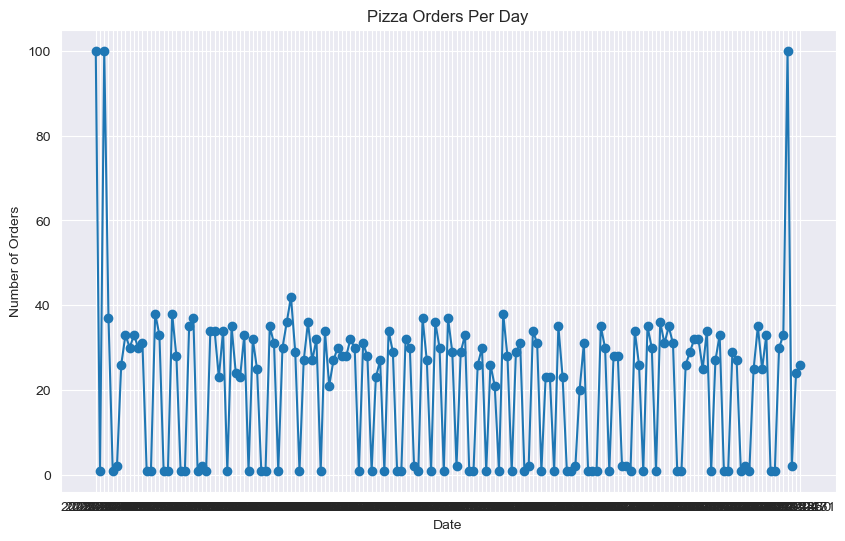

In [245]:
# Aggregate data to count orders per day
orders_per_day = df_ordered.groupby('order_date').size()

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(orders_per_day.index, orders_per_day.values, marker='o', linestyle='-')
plt.title('Pizza Orders Per Day')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Number of Orders')  # Label for the y-axis
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

In [246]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_holiday'] = df['order_date'].apply(is_holiday).astype(int)
df['is_birthday'] = df.apply(lambda row: row['order_date'].strftime('%m-%d') == row['dob'][5:], axis=1).astype(int)
df['average_price'] = df['final_prices'].apply(lambda prices: np.mean(list(prices.values())))

X = df[['month', 'day_of_week', 'is_holiday', 'is_birthday', 'average_price']]  # Features
y = df['ordered'].astype(int)  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data with the same scaler
X_test_scaled = scaler.transform(X_test)

In [247]:
# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)

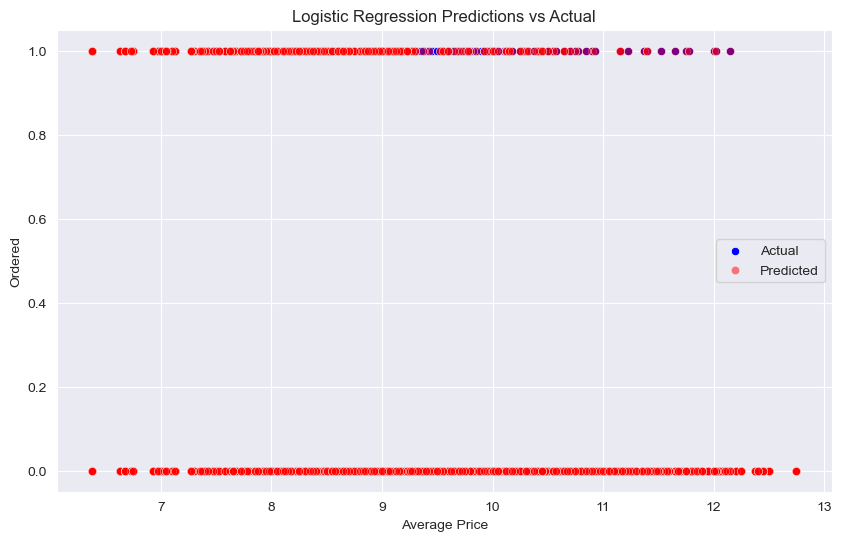

In [248]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['average_price'], y=y_test, color='blue', label='Actual')
sns.scatterplot(x=X_test['average_price'], y=predictions, color='red', label='Predicted', alpha=0.5)
plt.title('Logistic Regression Predictions vs Actual')
plt.xlabel('Average Price')
plt.ylabel('Ordered')
plt.legend()
plt.show()

In [249]:
# Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9860
           1       0.79      0.66      0.72      1090

    accuracy                           0.95     10950
   macro avg       0.88      0.82      0.85     10950
weighted avg       0.95      0.95      0.95     10950



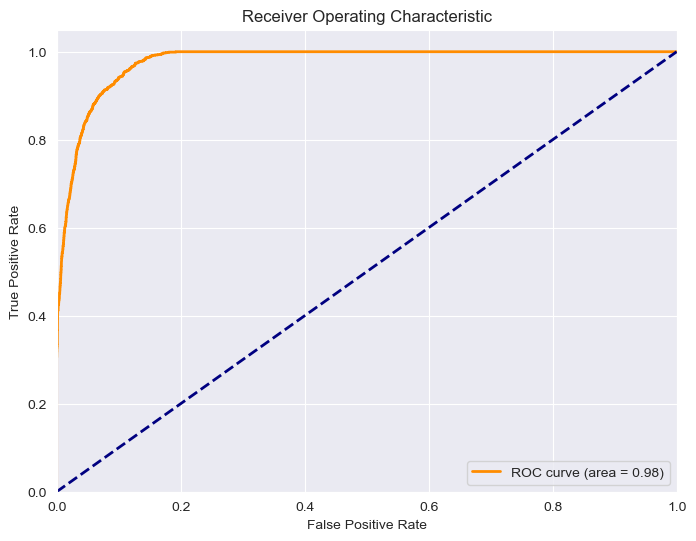

In [250]:
from sklearn.metrics import roc_curve, auc

# Calculate the probabilities of each class
probabilities = model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [251]:
from joblib import dump

# Assuming 'scaler' is your StandardScaler instance and 'model' is your trained model
dump(scaler, 'pizza_scaler.joblib')
dump(model, 'pizza_regression.joblib')

['pizza_regression.joblib']